# Connection to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


## connect different python file to the notebook

In [ ]:
import sys 
parentDir = F"/content/gdrive/MyDrive/final_project"
sys.path.append(parentDir)

In [ ]:
from Helper_func import *
from Scores import *

# Installations and data downloads

In [ ]:
! mkdir -p ~/.kaggle;
! cp kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c uw-madison-gi-tract-image-segmentation

100% 2.29G/2.30G [00:16<00:00, 114MB/s]
100% 2.30G/2.30G [00:16<00:00, 148MB/s]


In [ ]:
!unzip /content/uw-madison-gi-tract-image-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/case77/case77_day20/scans/slice_0121_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0122_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0123_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0124_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0125_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0126_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0127_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0128_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0129_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0130_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0131_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0132_266_266_1.50_

# Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import os
import cv2
import tensorflow as tf
from keras.layers import Input, Conv2D
from keras.models import Model
from tqdm import tqdm


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['number']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Upload the segemention file

In [ ]:
masks = pd.read_csv('train.csv')

In [ ]:
masks.id = masks.id.astype(str)
masks[['case_num','day_num','slice','scan_num']] = masks['id'].str.split('_',n=3, expand=True)
masks.drop(['slice'], axis = 1, inplace = True) 

### dropna

In [ ]:
masks_without_na = masks.dropna()

## Upload the paths of the images

In [ ]:
filelist = []
PATH = '/content/train/'

for root, dirs, files in os.walk(PATH):
	for file in files:
        #append the file name to the list
		filelist.append(os.path.join(root,file))
df_path = pd.DataFrame(sorted(filelist),columns=['path'])
df_path.head()

,path
0,/content/train/case101/case101_day20/scans/sli...
1,/content/train/case101/case101_day20/scans/sli...
2,/content/train/case101/case101_day20/scans/sli...
3,/content/train/case101/case101_day20/scans/sli...
4,/content/train/case101/case101_day20/scans/sli...


In [ ]:
print("No. of images = ", len(filelist))

No. of images =  38496


#### Split the path to id and the shape of the image

In [ ]:
df_ezer = df_path.path.str.split('/', expand=True)
df_ezer.sample(1)

,0,1,2,3,4,5,6
34833,,content,train,case81,case81_day28,scans,slice_0018_266_266_1.50_1.50.png


In [ ]:
df_ezer2 = df_ezer.loc[:,6].str.split('_', expand=True)
df_ezer2.sample(1)

,0,1,2,3,4,5
9313,slice,0130,360,310,1.50,1.50.png


In [ ]:
df_path.path = df_path.path.astype(str)
df_path['image_shape'] = list(zip(df_ezer2.loc[:,2],df_ezer2.loc[:,3]))

In [ ]:
df_path['id'] = df_ezer.loc[:,4]+"_"+df_ezer2.loc[:,0]+"_"+df_ezer2.loc[:,1]

In [ ]:
df_path.sample(1)

,path,image_shape,id
37963,/content/train/case90/case90_day22/scans/slice...,"(266, 266)",case90_day22_slice_0044


In [ ]:
#  Table with the path of the image and the corresponding segmentation mask in RLE-format.
masks_paths = pd.merge(masks, df_path)
masks_paths.sample(1)

,id,class,segmentation,case_num,day_num,scan_num,path,image_shape
27130,case122_day18_slice_0036,small_bowel,NaN,case122,day18,0036,/content/train/case122/case122_day18/scans/sli...,"(266, 266)"


## Create functions go over the images

In [ ]:
image_gen = generator_images(masks_paths)

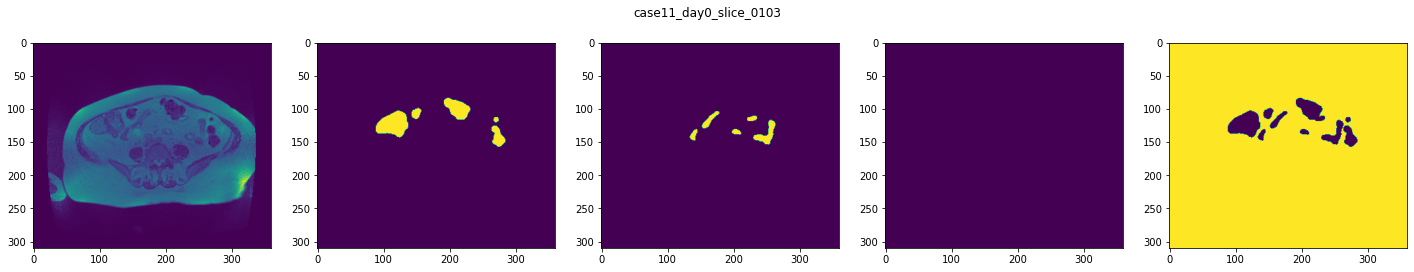

In [ ]:
img, img_seg, id_img = next(image_gen)
plot_image_mask(img[:,:,0], img_seg, id_img)

# Split the data

In [ ]:
train_ratio = 0.8
validation_ratio = 0.1 #from the test set
test_ratio = 0.1

## Split by day

In [ ]:
masks_without_na.day_num = masks_without_na.day_num.astype(str)
masks_without_na.day_num = masks_without_na.day_num.apply(lambda word: (''.join(filter(lambda i: i.isdigit(), word)))).astype(int)
masks_without_na.day_num.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


194    20
197    20
200    20
203    20
206    20
Name: day_num, dtype: int64

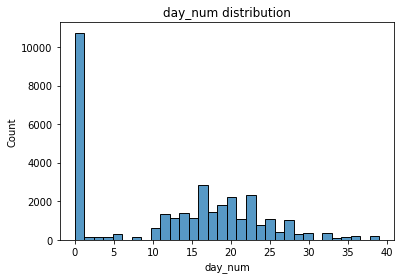

In [ ]:
sns.histplot(masks_without_na['day_num'])
plt.title('day_num distribution')
plt.xlabel('day_num');

### Split to train and test set

In [ ]:
day_num_count = masks_without_na.groupby('day_num').count().id/masks_without_na.shape[0]

In [ ]:
import itertools
import operator
lis=list(itertools.accumulate(day_num_count, add))

In [ ]:
ind = [index for index,value in enumerate(lis) if value > train_ratio][0]
ind

20

In [ ]:
ind_day = masks_without_na.groupby('day_num').count().index[ind]
ind_day

22

In [ ]:
features = masks_without_na.drop(columns='segmentation')
target = masks_without_na['segmentation']

In [ ]:
x_train=features[features.day_num < ind_day]
y_train=target[features.day_num < ind_day]
x_val_test=features[features.day_num >= ind_day]
y_val_test=target[features.day_num >= ind_day]

In [ ]:
print(f"Percentage of data used for training:{x_train.shape[0]/features.shape[0]}")
print(f"Percentage of data used for testing:{x_val_test.shape[0]/features.shape[0]}")

Percentage of data used for training:0.7848907498599357
Percentage of data used for testing:0.2151092501400643


### Split train set to val and test set

In [ ]:
day_num_count = x_val_test.groupby('day_num').count().id/x_val_test.shape[0]
lis=list(itertools.accumulate(day_num_count, add))
ind = [index for index,value in enumerate(lis) if value > 0.5][0]
ind_day = x_val_test.groupby('day_num').count().index[ind]

In [ ]:
x_test=x_val_test[x_val_test.day_num < ind_day]
y_test=y_val_test[x_val_test.day_num < ind_day]
x_val=x_val_test[x_val_test.day_num >= ind_day]
y_val=y_val_test[x_val_test.day_num >= ind_day]

In [ ]:
print(f"Percentage of data used for validation:{x_val.shape[0]/features.shape[0]}")
print(f"Percentage of data used for testing:{x_test.shape[0]/features.shape[0]}")

Percentage of data used for validation:0.12417067201368207
Percentage of data used for testing:0.09093857812638222


In [ ]:
assert set(x_train['day_num']) & set(x_val['day_num']) == set()
assert set(x_val['day_num']) & set(x_test['day_num']) == set()

In [ ]:
x_train.reset_index(drop=True, inplace=True)

## Split by case

In [ ]:
from sklearn.model_selection import GroupShuffleSplit

gs_1 = GroupShuffleSplit(n_splits=1, test_size=1 - train_ratio, random_state=42)
train_ix, val_test_ix = next(gs_1.split(x_train,y_train, groups=x_train['case_num']))
x_train_case=x_train.iloc[train_ix,:]
y_train_case=y_train.iloc[train_ix]
x_val_test_case=x_train.iloc[val_test_ix,:]
y_val_test_case=y_train.iloc[val_test_ix]

gs_2 = GroupShuffleSplit(n_splits=1, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)
val_ix, test_ix = next(gs_2.split(x_val_test_case, y_val_test_case, groups=x_val_test_case['case_num']))
x_val_case=x_val_test_case.iloc[val_ix,:]
y_val_case=y_val_test_case.iloc[val_ix]
x_test_case=x_val_test_case.iloc[test_ix,:]
y_test_case=y_val_test_case.iloc[test_ix]

In [ ]:
print(f"Percentage of case_num in training: {x_train_case['case_num'].nunique()/x_train['case_num'].nunique()}")
print(f"Percentage of case_num in validation: {x_val_case['case_num'].nunique()/x_train['case_num'].nunique()}")
print(f"Percentage of case_num in testing: {x_test_case['case_num'].nunique()/x_train['case_num'].nunique()}")

Percentage of case_num in training: 0.8
Percentage of case_num in validation: 0.09411764705882353
Percentage of case_num in testing: 0.10588235294117647


In [ ]:
assert set(x_train_case['case_num']) & set(x_val_case['case_num']) == set()
assert set(x_val_case['case_num']) & set(x_test_case['case_num']) == set()

In [ ]:
print(f"Percentage of data used for training:{x_train_case.shape[0]/x_train.shape[0]}")
print(f"Percentage of data used for testing:{x_test_case.shape[0]/x_train.shape[0]}")
print(f"Percentage of data used for validation:{x_val_case.shape[0]/x_train.shape[0]}")

Percentage of data used for training:0.8030655947103463
Percentage of data used for testing:0.08486738297392742
Percentage of data used for validation:0.1120670223157262


In [ ]:
print(f"case_num in training: {x_train_case['case_num'].nunique()}")
print(f"case_num in validation: {x_val_case['case_num'].nunique()}")
print(f"case_num in testing: {x_test_case['case_num'].nunique()}")

case_num in training: 68
case_num in validation: 8
case_num in testing: 9


## Combine the splits

In [ ]:
x_train = x_train_case

In [ ]:
x_val = pd.concat([x_val_case,x_val])


In [ ]:
x_test = pd.concat([x_test_case,x_test])

In [ ]:
print(f"Percentage of data used for training:{x_train.shape[0]/masks_without_na.shape[0]}")
print(f"Percentage of data used for testing:{x_test.shape[0]/masks_without_na.shape[0]}")
print(f"Percentage of data used for validation:{x_val.shape[0]/masks_without_na.shape[0]}")

Percentage of data used for training:0.630318756818919
Percentage of data used for testing:0.15755020198743844
Percentage of data used for validation:0.21213104119364257


## Train/valid/test dataframes to create generators

In [ ]:
train_img_paths = masks_paths[masks_paths['id'].isin(x_train.id)]
len(train_img_paths)/3

10356.0

In [ ]:
val_img_paths = masks_paths[masks_paths['id'].isin(x_val.id)]
len(val_img_paths)/3

3586.0

In [ ]:
test_img_paths = masks_paths[masks_paths['id'].isin(x_test.id)]
len(test_img_paths)/3

2648.0

In [ ]:
images_per_classes = train_img_paths.dropna().groupby(by = 'id').agg(number_of_classes = ('class', 'count')).value_counts().sort_index()
images_per_classes

number_of_classes
1                    1435
2                    6822
3                    2099
dtype: int64

In [ ]:
train_img_paths[train_img_paths.id=='case123_day20_slice_0084']#.path.iloc[0]

,id,class,segmentation,case_num,day_num,scan_num,path,image_shape
249,case123_day20_slice_0084,large_bowel,17215 4 17479 8 17745 9 18010 12 18275 14 1854...,case123,day20,0084,/content/train/case123/case123_day20/scans/sli...,"(266, 266)"
250,case123_day20_slice_0084,small_bowel,21436 4 21701 7 21966 9 22231 11 22497 12 2276...,case123,day20,0084,/content/train/case123/case123_day20/scans/sli...,"(266, 266)"
251,case123_day20_slice_0084,stomach,11045 14 11308 19 11572 23 11838 24 12103 27 1...,case123,day20,0084,/content/train/case123/case123_day20/scans/sli...,"(266, 266)"


# Baseline Model

* predict only background and find the dice coef

In [ ]:
IM_DIM = (256, 256)

In [ ]:
y = np.zeros((256,256,4))
y[:,:,3]=1

In [ ]:
from tqdm import tqdm
dice = [] 
for img, img_seg, id_img in tqdm(generator_images(train_img_paths)):
  img_seg = cv2.resize(img_seg, IM_DIM, interpolation=cv2.INTER_NEAREST)
  dice.append(dice_coef_multilabel(y, img_seg, 4))

10356it [02:35, 66.49it/s]


In [ ]:
sum(dice)/len(dice)

0.47880644024812025

(array([2099.,    0.,    0.,    0., 1092., 5730.,    0.,    0.,    0.,
        1435.]),
 array([0.23345918, 0.28510781, 0.33675645, 0.38840509, 0.44005372,
        0.49170236, 0.54335099, 0.59499963, 0.64664826, 0.6982969 ,
        0.74994554]),
 <a list of 10 Patch objects>)

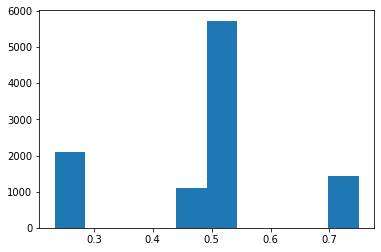

In [ ]:
plt.hist(dice)

# model

In [ ]:
!pip3 install tensorflow==2.2
!pip3 install keras==2.3.1
!pip3 install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 516.2 MB 4.3 kB/s 
     |████████████████████████████████| 3.0 MB 33.2 MB/s 
     |████████████████████████████████| 454 kB 57.9 MB/s 
     |████████████████████████████████| 2.9 MB 35.3 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 377 kB 4.0 MB/s 
     |████████████████████████████████| 50 kB 7.7 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import segmentation_models as sm
import keras
keras.backend.set_image_data_format('channels_last')

Segmentation Models: using `keras` framework.


In [ ]:
# Set hyperparameters to the model
BATCHSIZE = 32
BACKBONE = 'resnet34'
IM_DIM = (256, 256)
ENCODER_WEIGHTS = 'imagenet'
NUM_CLASSES = 4
MODEL_NAME = 'classifier_cvresize_iouth.ckpt'
PATH = f"/content/gdrive/MyDrive/final_project/{MODEL_NAME}"
LR = 0.0001 
EPOCHS = 5

In [ ]:
# Create the train and validation generators
traingen = generator_batch_images(IM_DIM, train_img_paths, batchsize=BATCHSIZE)
valgen = generator_batch_images(IM_DIM, val_img_paths, batchsize=BATCHSIZE)
# check that the creation work
img, img_seg = next(traingen)
img, img_seg = next(valgen)

In [ ]:
def calc_steps(data_len, batchsize):
    return (data_len + batchsize - 1) // batchsize

# Calculate the steps per epoch
train_steps = calc_steps(len(train_img_paths), BATCHSIZE)
val_steps = calc_steps(len(val_img_paths), BATCHSIZE)

In [ ]:
# # map N channels data to 3 channels, in our case 1 channel beacuse the image gray scale
# N = 1

# base_model = sm.Unet(backbone_name = BACKBONE, classes = NUM_CLASSES, encoder_weights = ENCODER_WEIGHTS)
# inp = Input(shape=(None, None, N))
# l1 = Conv2D(3, (1, 1))(inp) 
# out = base_model(l1)

# model = Model(inp, out, name=base_model.name)

In [ ]:
# Define callbacks
callback_save = keras.callbacks.ModelCheckpoint(filepath = PATH, monitor = 'val_loss', save_best_only = True, save_weights_only = True, verbose=1)
callback_early = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)
callbacks=[callback_early,callback_save]

In [ ]:
import tensorflow as tf
import keras.backend as K

callback_save = keras.callbacks.ModelCheckpoint(filepath=PATH, monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1)

In [ ]:
model = sm.Unet(BACKBONE, input_shape=(None, None, 1), classes = 4, encoder_weights=None, activation='softmax')


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(LR),
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.IOUScore(threshold=0.5)]
)

In [ ]:
# model.load_weights(PATH)

In [ ]:
# model.summary()

In [ ]:
history = model.fit_generator(
    traingen, 
    steps_per_epoch=train_steps, 
    epochs=EPOCHS, # Change this to a larger number to train for longer
    validation_data=valgen, 
    validation_steps=val_steps, 
    verbose=1,
    max_queue_size=5,  # Change this number based on memory restrictions
    callbacks=[callback_early,callback_save]
)

Epoch 1/5
971/971 [==============================] - 917s 944ms/step - loss: 0.5896 - iou_score: 0.5742 - val_loss: 0.5086 - val_iou_score: 0.5498

Epoch 00001: val_loss improved from inf to 0.50862, saving model to /content/gdrive/MyDrive/classifier_cvresize_iouth.ckpt


/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Epoch 2/5
971/971 [==============================] - 894s 920ms/step - loss: 0.1952 - iou_score: 0.8381 - val_loss: 0.4657 - val_iou_score: 0.5723

Epoch 00002: val_loss improved from 0.50862 to 0.46571, saving model to /content/gdrive/MyDrive/classifier_cvresize_iouth.ckpt
Epoch 3/5
971/971 [==============================] - 892s 919ms/step - loss: 0.1453 - iou_score: 0.8772 - val_loss: 0.4916 - val_iou_score: 0.5562

Epoch 00003: val_loss did not improve from 0.46571
Epoch 4/5
971/971 [==============================] - 891s 918ms/step - loss: 0.1230 - iou_score: 0.8955 - val_loss: 0.4735 - val_iou_score: 0.5743

Epoch 00004: val_loss did not improve from 0.46571
Epoch 5/5
970/971 [============================>.] - ETA: 0s - loss: 0.1112 - iou_score: 0.9051

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluate performance

In [ ]:
# load pretrained weights
model.load_weights(PATH)

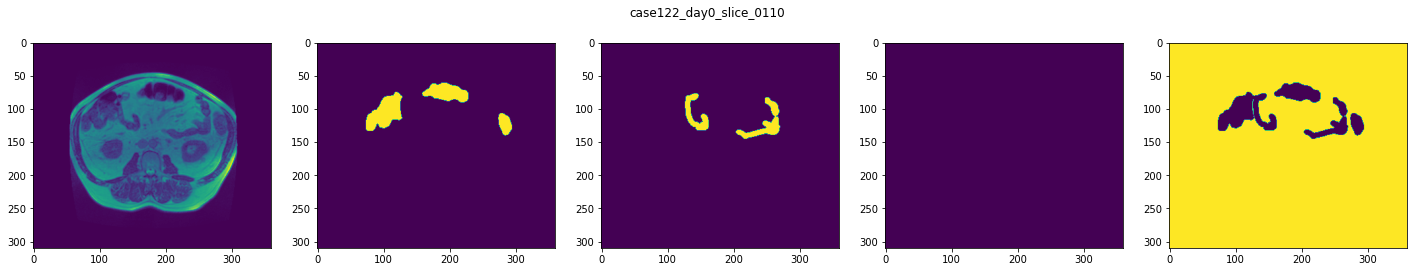

In [ ]:
image_gen = generator_images(train_img_paths)
img, img_seg, id_img = next(image_gen)
plot_image_mask(img[:,:,0],img_seg, id_img)

In [ ]:
image_gen = generator_images(train_img_paths)

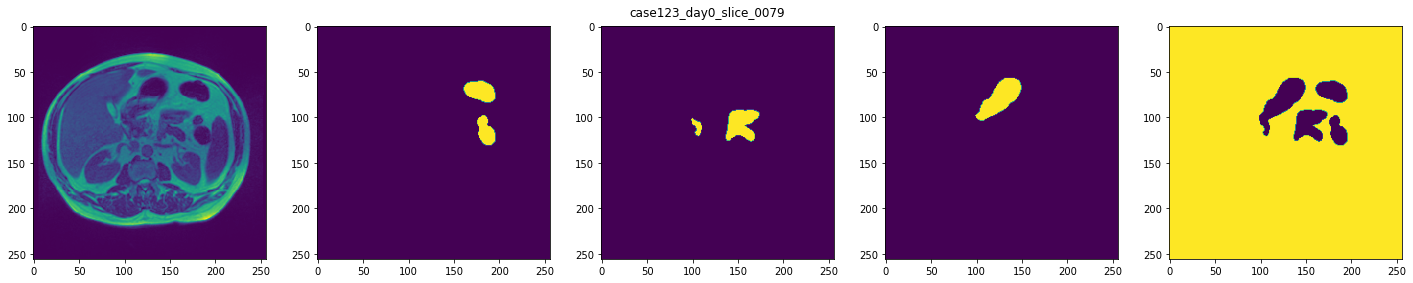

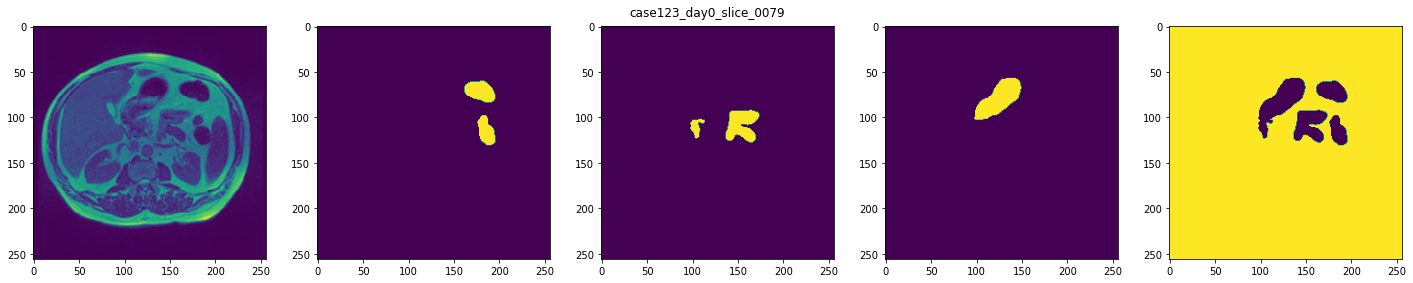

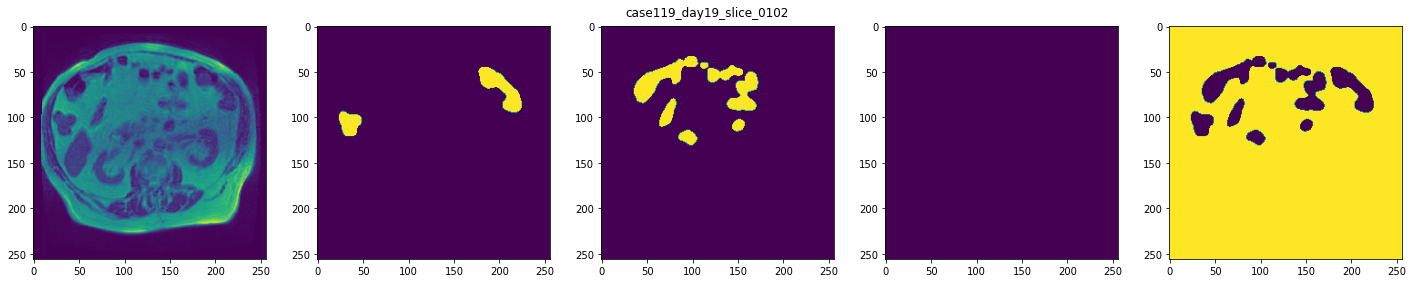

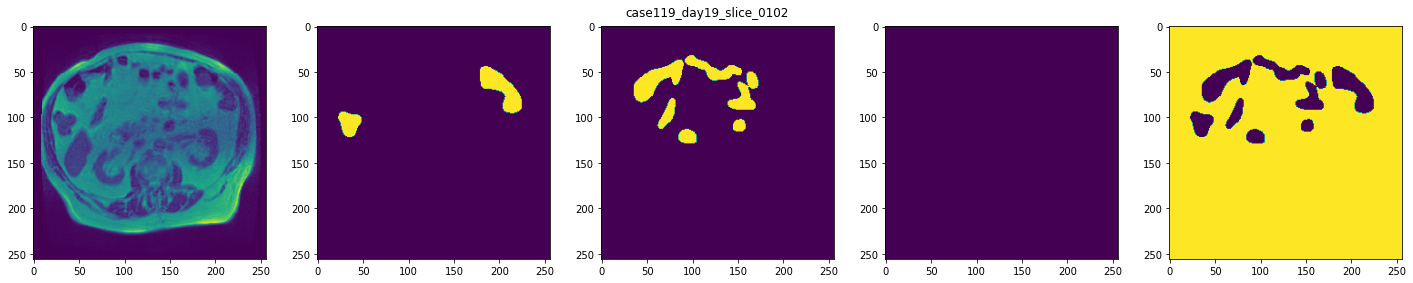

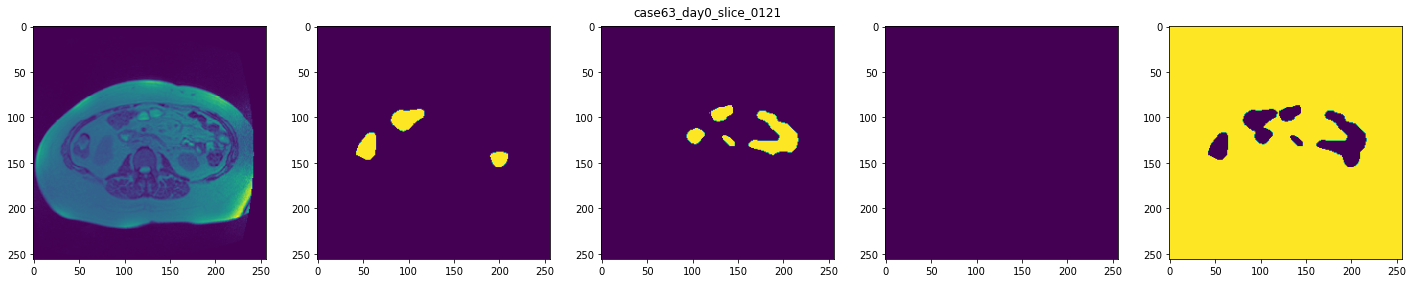

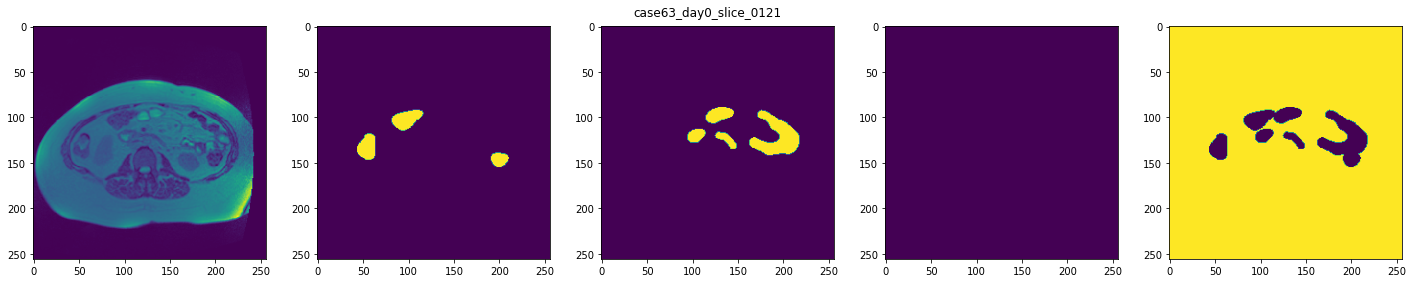

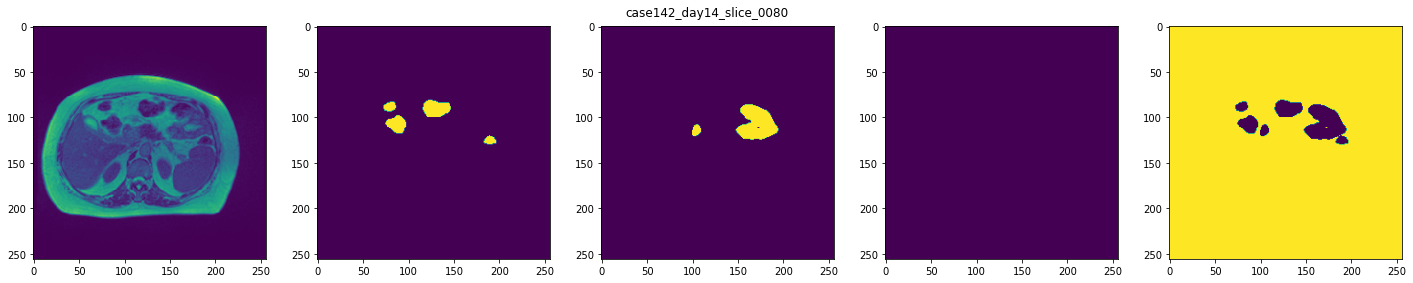

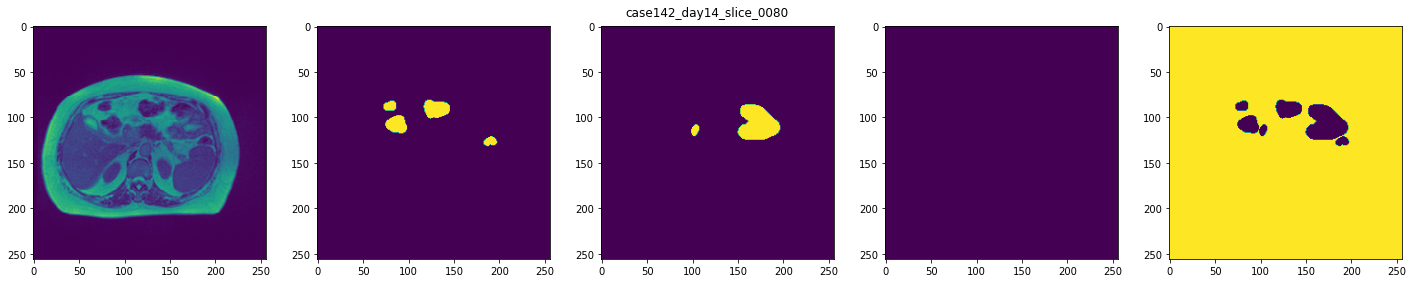

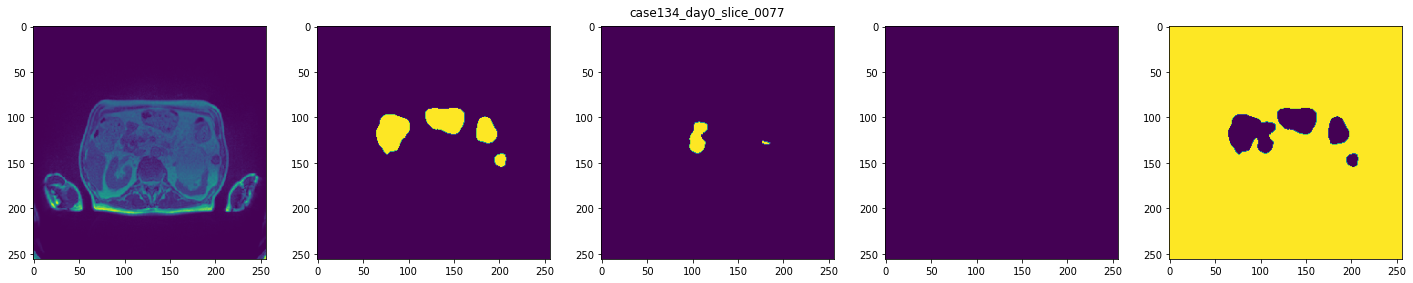

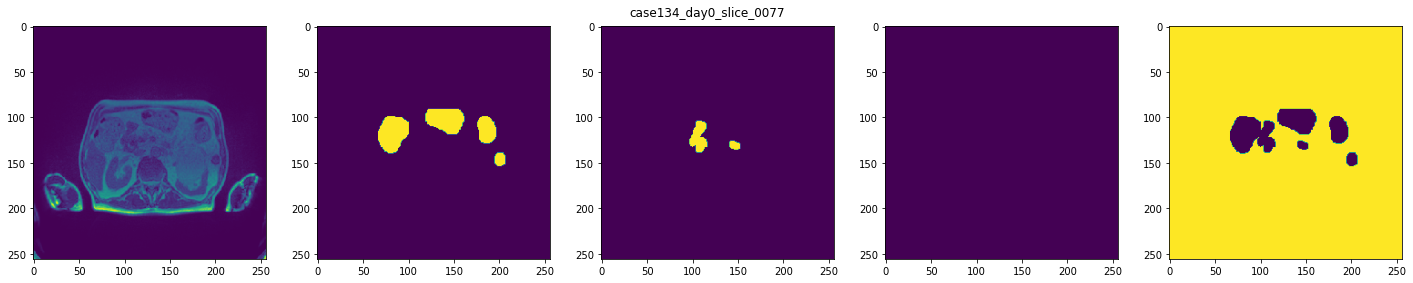

In [ ]:
for number in range(5):

  img, img_seg, id_img = next(image_gen)

  img = cv2.resize(img, IM_DIM, interpolation=cv2.INTER_NEAREST)
  img_seg = cv2.resize(img_seg, IM_DIM, interpolation=cv2.INTER_NEAREST)

  x = img.reshape(1, 256, 256, 1)

  y = np.round(model.predict(x))

  plot_image_mask(img, y[0,:,:,:], id_img, "predicated")
  plot_image_mask(img, img_seg, id_img)

In [ ]:
dice_score = dice_coef_multilabel(y[0,:,:,:], img_seg, 4)
print(f'For A and B {dice_score}')

For A and B 0.9570407910452324


In [ ]:
# dice = [] 
# for img,img_seg, id_img in tqdm(generator_images(train_img_paths)):
#     img = cv2.resize(img, IM_DIM, interpolation=cv2.INTER_NEAREST)
#     img_seg = cv2.resize(img_seg, IM_DIM, interpolation=cv2.INTER_NEAREST)
#     x = img.reshape(1, 256, 256, 1)
#     y = np.round(model.predict(x))
#     img_seg = cv2.resize(img_seg, IM_DIM, interpolation=cv2.INTER_NEAREST)
#     dice.append(dice_coef_multilabel(y[0,:,:,:], img_seg, 4))
# sum(dice)/len(dice)

3577it [25:18,  2.36it/s]


KeyboardInterrupt: ignored

In [ ]:
# plt.hist(dice)

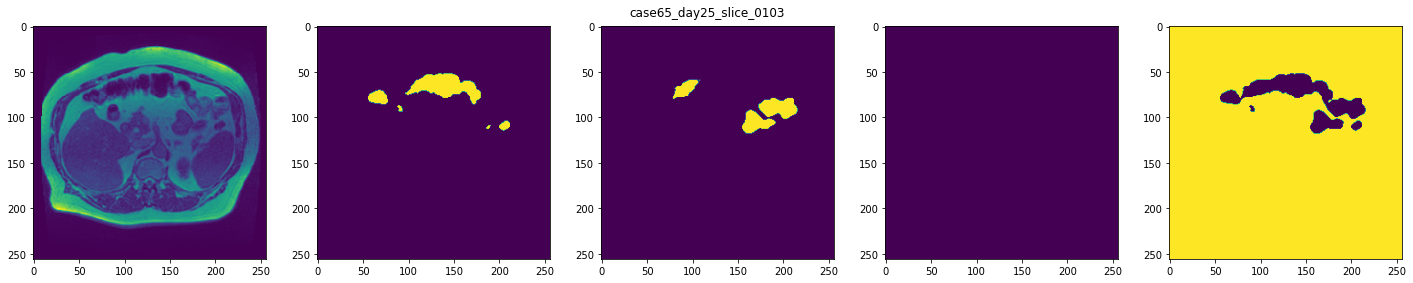

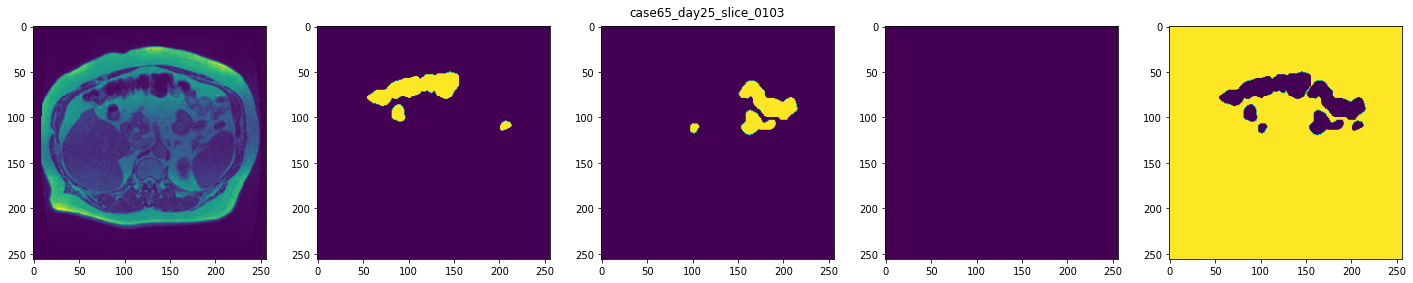

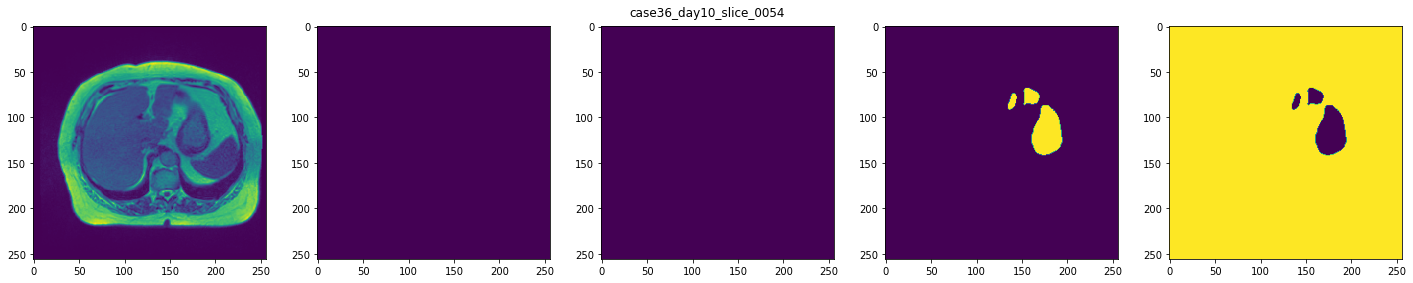

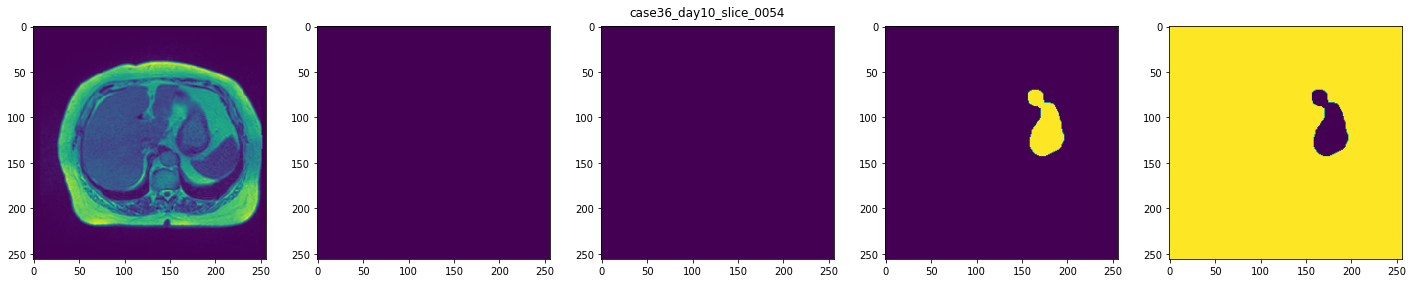

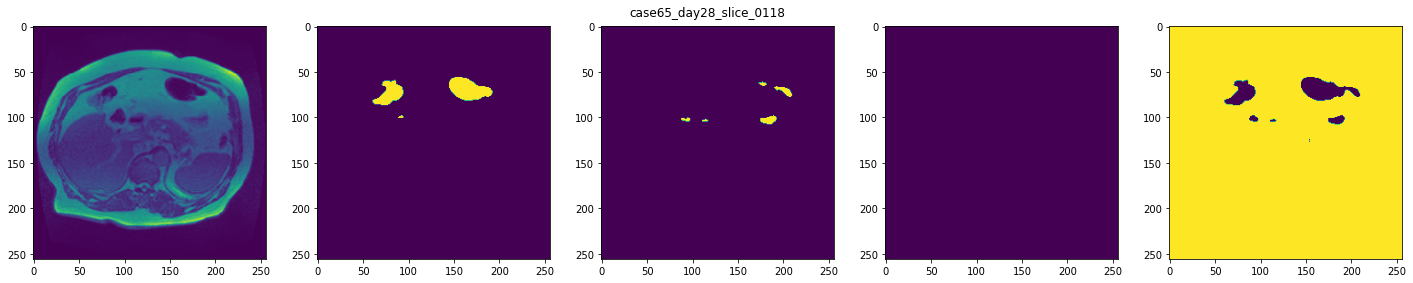

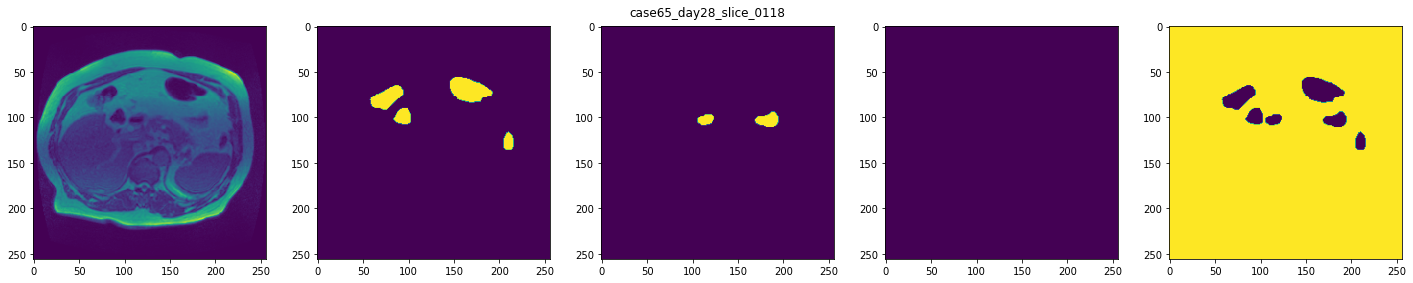

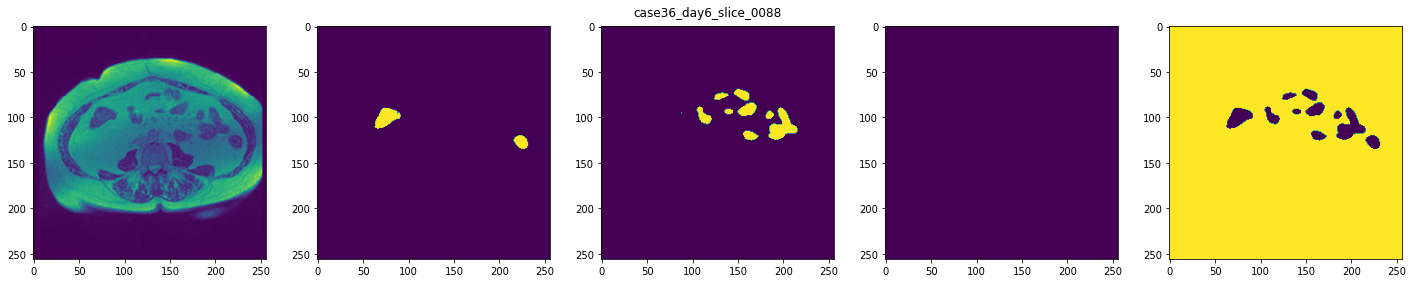

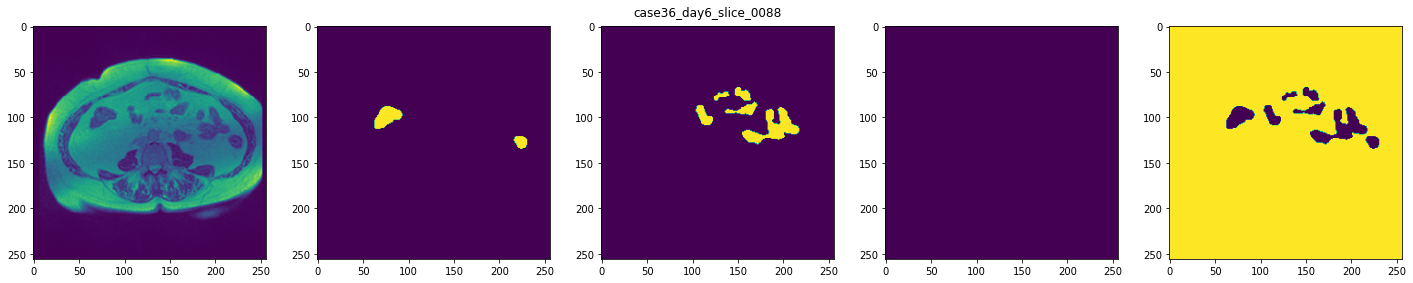

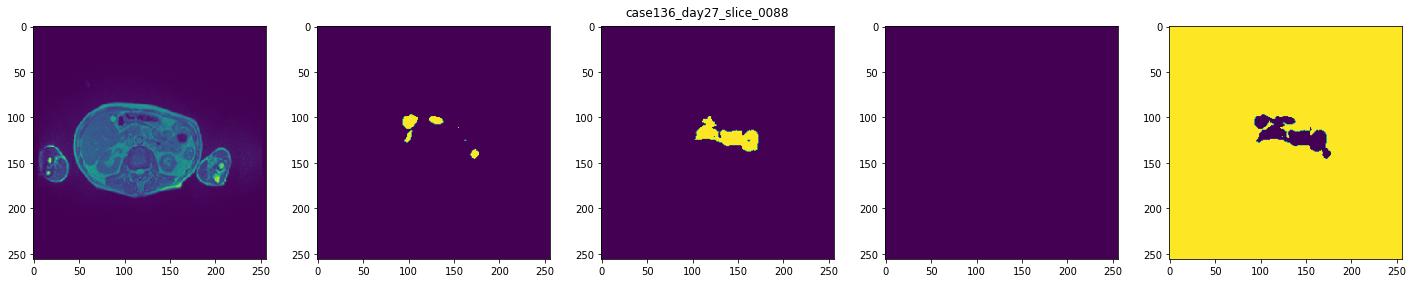

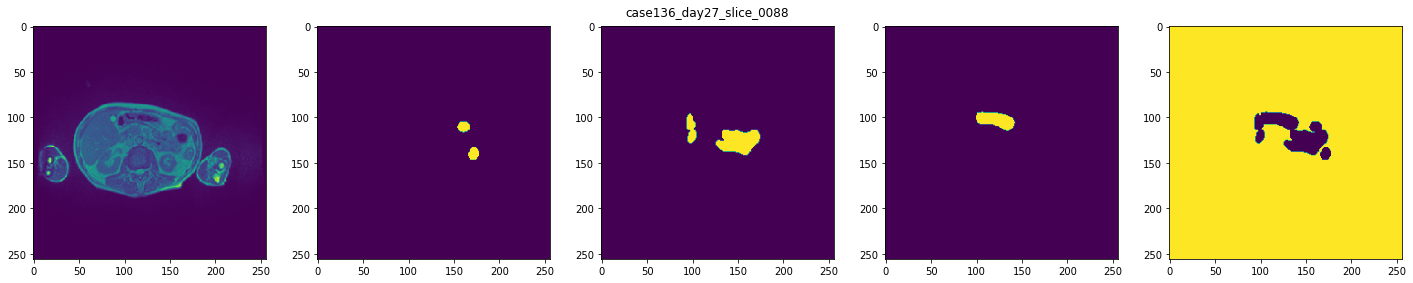

In [ ]:
image_gen = generator_images(val_img_paths)
for number in range(5):

  img, img_seg, id_img = next(image_gen)

  img = cv2.resize(img, IM_DIM, interpolation=cv2.INTER_NEAREST)
  img_seg = cv2.resize(img_seg, IM_DIM, interpolation=cv2.INTER_NEAREST)

  x = img.reshape(1, 256, 256, 1)

  y = np.round(model.predict(x))

  plot_image_mask(img, y[0,:,:,:], id_img)
  plot_image_mask(img, img_seg, id_img)

In [ ]:
# dice = [] 
# for img,img_seg, id_img in tqdm(generator_images(val_img_paths)):
#     img = cv2.resize(img, IM_DIM, interpolation=cv2.INTER_NEAREST)
#     img_seg = cv2.resize(img_seg, IM_DIM, interpolation=cv2.INTER_NEAREST)
#     x = img.reshape(1, 256, 256, 1)
#     y = np.round(model.predict(x))
#     img_seg = cv2.resize(img_seg, im_dim, interpolation=cv2.INTER_NEAREST)
#     dice.append(dice_coef_multilabel(y, img_seg, 4))
# sum(dice)/len(dice)

In [ ]:
# plt.hist(dice)